# Movie Recommender - Siddharth Singh

Recommender systems encompass a class of techniques and algorithms that can suggest “relevant” items to users. They predict future behavior based on past data through a multitude of techniques. Utilizing the principles of iten-based collaborative filtering, I use the KNN clustering algorithm to recommend similar movies to users.

In [66]:
# import statements
import numpy as np
import pandas as pd
from surprise import SVD
from surprise import Reader, Dataset
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## Intro and EDA

Here, we look at the data structure and format it to better process it. 

In [69]:
# read in the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# movie dataset
movies = pd.read_csv('ml-latest-small/movies.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [47]:
ratings.shape

(100836, 4)

The above dataframe is hard to interpret, and it makes sense to pivot it to make it easier to understand.

In [48]:
# pivot data to enable easy interpretation and processing
data = ratings.pivot(index='movieId',columns='userId',values='rating')
data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# replace the NAs with 0s
data.fillna(0,inplace=True)
data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Data is in this format is far simpler to interpret (eg, We can see that userID '1' has rated movies '1' and '3', but not any other in the first five films), and will be convinient to process.

## Cleaning Data + Visualizations

It makes sense to visualize the ratings users are assigning to movies as a whole (Whether people on average like the movies in this dataset or not).

Text(0, 0.5, 'No. of users voted')

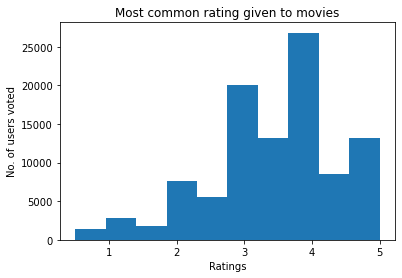

In [50]:
ratings['rating'].plot(kind='hist')
plt.title('Most common rating given to movies')
plt.xlabel('Ratings')
plt.ylabel('No. of users voted')

It appears that most people like the movies in this dataset, with 4 stars being the most common rating.

A lot of the dataset consists of zeros, as not everyone has rated every film. This creates a problem, as we wouldn’t want movies that were rated by a small number of users because it’s not credible enough. Similarly, users who have rated only a handful of movies should also not be taken into account.

In [51]:
# Count the number of users that rated each movie
no_users = ratings.groupby('movieId')['rating'].agg('count')

# Count the number of movies that were rated by each user
no_movies = ratings.groupby('userId')['rating'].agg('count')

We will reduce the noise by adding some filters for the final dataset. To qualify a movie, a minimum of 10 users should have voted the particular movie. To qualify a user, a minimum of 50 movies should have been voted by the user.

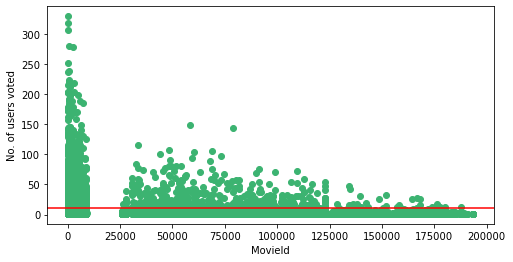

In [52]:
f,ax = plt.subplots(1,1,figsize=(8,4))
plt.scatter(no_users.index,no_users,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

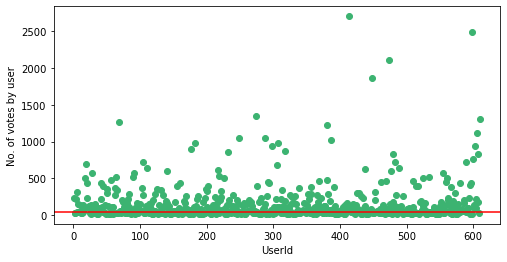

In [53]:
f,ax = plt.subplots(1,1,figsize=(8,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [54]:
# Subset data to only include movies that have been rated by 10 or more users
data = data.loc[no_user_voted[no_user_voted >= 10].index,:]

# Subset data to only include users that have rated 50 or more movies
data = data.loc[:,no_movies_voted[no_movies_voted >= 50].index]

In [56]:
data

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since most of the data consists of '0s', we need to eliminate the sparsity. We do this by using the csr_matrix function from the scipy library, where values are assigned as rows and column index, and no sparse values are present.

In [57]:
# create the csr matrix
csr_data = csr_matrix(data.values)

# reset the indices
data.reset_index(inplace=True)

In [88]:
print(csr_data)

  (0, 0)	4.0
  (0, 3)	4.5
  (0, 6)	2.5
  (0, 8)	4.5
  (0, 9)	3.5
  (0, 10)	4.0
  (0, 12)	3.5
  (0, 16)	3.0
  (0, 19)	5.0
  (0, 20)	3.0
  (0, 21)	3.0
  (0, 26)	5.0
  (0, 29)	5.0
  (0, 30)	4.0
  (0, 32)	3.0
  (0, 35)	5.0
  (0, 39)	5.0
  (0, 40)	4.0
  (0, 41)	4.0
  (0, 42)	2.5
  (0, 44)	4.5
  (0, 47)	0.5
  (0, 48)	4.0
  (0, 51)	2.5
  (0, 54)	4.0
  :	:
  (2266, 209)	4.0
  (2266, 352)	1.5
  (2266, 364)	4.0
  (2266, 376)	4.5
  (2267, 38)	3.5
  (2267, 63)	3.0
  (2267, 100)	0.5
  (2267, 130)	4.5
  (2267, 160)	4.5
  (2267, 240)	0.5
  (2267, 260)	4.5
  (2267, 323)	2.0
  (2267, 352)	2.0
  (2267, 364)	5.0
  (2267, 372)	3.5
  (2268, 38)	4.0
  (2268, 63)	5.0
  (2268, 149)	2.5
  (2268, 159)	4.5
  (2268, 160)	5.0
  (2268, 190)	5.0
  (2268, 209)	4.0
  (2268, 240)	3.0
  (2268, 323)	3.5
  (2268, 364)	4.0


The dataset is ready for training, and we can build the ML model now.

## ML Model + Recommendation

In [67]:
knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=20)

In [128]:
def get_movie_recommendation(movie_name, n):
    # get all movies what contain the given movie name (eg if input value is Batman, return all instances of Batman)
    movie_list = movies[movies['title'].str.contains(movie_name)] 
    
    if len(movie_list):
        # get the movie index from the input name
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = data[data['movieId'] == movie_idx].index[0]
        
        # find the nearest neighbors
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors = n + 1)    
        
        # create a list with the movie index and its corresponding distance
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        
        # create a dataframe displaying the 'n' recommended films
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = data.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n + 1))
        return df
    else:
        return "No movies found. Please check your input"

In [142]:
get_movie_recommendation('Star Wars', 20)

,Title,Distance
1,Alien (1979),0.374404
2,"Princess Bride, The (1987)",0.369952
3,Indiana Jones and the Temple of Doom (1984),0.368806
4,"Silence of the Lambs, The (1991)",0.368655
5,Groundhog Day (1993),0.366671
6,Fargo (1996),0.365054
7,Men in Black (a.k.a. MIB) (1997),0.364400
8,Jurassic Park (1993),0.364012
9,"Godfather, The (1972)",0.355067
10,Independence Day (a.k.a. ID4) (1996),0.354371
